## Pyro GMM
This is the Pyro inference example for Gaussian mixture models from 
https://github.com/mcdickenson/em-gaussian/blob/master/em-gaussian-pyro.py,
Which is a 2D extension of the GMM example given in the pyro documentation. 
The [accompanying blog](https://mattdickenson.com/2018/11/18/gmm-python-pyro/) gives some descriptions,
but the code is fairly self-explanatory.

In [8]:
import os
from collections import defaultdict
import numpy as np
import scipy.stats
import torch
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.contrib.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

Training a MAP estimator

In [2]:
@config_enumerate(default='parallel')
@poutine.broadcast
def model(data):
    # Global variables
    weights = pyro.param('weights', torch.FloatTensor([0.5]), constraint=constraints.unit_interval)
    scales = pyro.param('scales', torch.tensor([[[1., 0.], [0., 2.]], [[3., 0.], [0., 4.]]]), constraint=constraints.positive)
    locs = pyro.param('locs', torch.tensor([[1., 2.], [3., 4.]]))
    
    with pyro.iarange('data', data.size(0)):
        # Local variables
        assignment = pyro.sample('assignment', dist.Bernoulli(torch.ones(len(data)) * weights)).to(torch.int64)
        pyro.sample('obs', dist.MultivariateNormal(locs[assignment], scales[assignment]), obs=data)

In [3]:
@config_enumerate(default='parallel')
@poutine.broadcast
def full_guide(data):
    with pyro.iarange('data', data.size(0)):
        # Local variables
        assignment_probs = pyro.param('assignment_probs', torch.ones(len(data)) / K,
                                     constraint=constraints.unit_interval)
        pyro.sample('assignment', dist.Bernoulli(assignment_probs), infer={'enumerate': 'sequential'})

In [4]:
def initialize(data):
    pyro.clear_param_store()
    
    optim = pyro.optim.Adam({'lr': 0.1, 'betas':[0.8, 0.99]})
    elbo = TraceEnum_ELBO(max_iarange_nesting=1)
    svi = SVI(model, full_guide, optim, loss=elbo)
    
    # Initialiwe weights to uniform
    pyro.param('auto_weights', 0.5 * torch.ones(K), constraint=constraints.simplex)
    
    # Assume half of the data variance is due to intra-component noise.
    var = (data.var() / 2).sqrt()
    pyro.param('auto_scale', torch.tensor([var]*4), constraint=constraints.positive)
    
    # Initialize means from a subsample of data
    pyro.param('auto_locs', data[torch.multinomial(torch.ones(len(data)) / len(data), K)])
    
    loss = svi.loss(model, full_guide, data)
    
    return loss, svi

In [5]:
def get_samples():
    num_samples = 100

    # 2 clusters
    # note that both covariance matrices are diagonal
    mu1 = torch.tensor([0., 5.])
    sig1 = torch.tensor([[2., 0.], [0., 3.]])

    mu2 = torch.tensor([5., 0.])
    sig2 = torch.tensor([[4., 0.], [0., 1.]])

    # generate samples
    dist1 = dist.MultivariateNormal(mu1, sig1)
    samples1 = [pyro.sample('samples1', dist1) for _ in range(num_samples)]

    dist2 = dist.MultivariateNormal(mu2, sig2)
    samples2 = [pyro.sample('samples2', dist2) for _ in range(num_samples)]

    data = torch.cat((torch.stack(samples1), torch.stack(samples2)))
    return data

In [6]:
def plot(data, mus=None, sigmas=None, colors='black', figname='fig.png'):
    # Create figure
    fig = plt.figure()

    # Plot data
    x = data[:, 0]
    y = data[:, 1]
    plt.scatter(x, y, 24, c=colors)

    # Plot cluster centers
    if mus is not None:
        x = [float(m[0]) for m in mus]
        y = [float(m[1]) for m in mus]
        plt.scatter(x, y, 99, c='red')

    # Plot ellipses for each cluster
    if sigmas is not None:
        for sig_ix in range(K):
            ax = fig.gca()
            cov = np.array(sigmas[sig_ix])
            lam, v = np.linalg.eig(cov)
            lam = np.sqrt(lam)
            ell = Ellipse(xy=(x[sig_ix], y[sig_ix]),
                          width=lam[0]*4, height=lam[1]*4,
                          angle=np.rad2deg(np.arccos(v[0, 0])),
                          color='blue')
            ell.set_facecolor('none')
            ax.add_artist(ell)

    # Save figure
    #fig.savefig(figname)

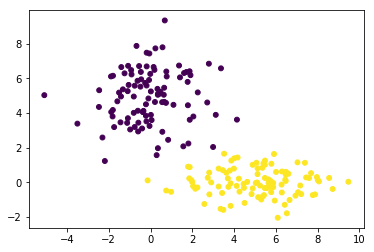

In [9]:
pyro.enable_validation(True)
pyro.set_rng_seed(42)

# Create model with a fixed number of components
K = 2

data = get_samples()

global_guide = AutoDelta(poutine.block(model, expose=['weights', 'locs', 'scales']))
global_guide = config_enumerate(global_guide, 'parallel')
_, svi = initialize(data)

true_colors = [0] * 100 + [1] * 100
plot(data, colors=true_colors, figname='pyro_init.png')

locs: tensor([[1.1000, 2.1000],
        [2.9000, 3.9000]], requires_grad=True)
scales: tensor([[[1.1052, 0.0000],
         [0.0000, 2.2103]],

        [[3.3155, 0.0000],
         [0.0000, 4.4207]]], grad_fn=<AddBackward0>)
weights = tensor([0.5000], grad_fn=<SigmoidBackward>)
locs: tensor([[2.0690, 3.0228],
        [2.7500, 2.2505]], requires_grad=True)
scales: tensor([[[5.5456, 0.0000],
         [0.0000, 7.5187]],

        [[9.9789, 0.0000],
         [0.0000, 7.4052]]], grad_fn=<AddBackward0>)
weights = tensor([0.7131], grad_fn=<SigmoidBackward>)
locs: tensor([[0.6496, 4.6208],
        [4.7642, 0.2020]], requires_grad=True)
scales: tensor([[[5.3102, 0.0000],
         [0.0000, 4.2118]],

        [[5.4851, 0.0000],
         [0.0000, 1.7956]]], grad_fn=<AddBackward0>)
weights = tensor([0.4889], grad_fn=<SigmoidBackward>)
locs: tensor([[-6.6762e-04,  4.8963e+00],
        [ 5.0099e+00,  1.3637e-02]], requires_grad=True)
scales: tensor([[[2.5315, 0.0000],
         [0.0000, 2.6476]],

      

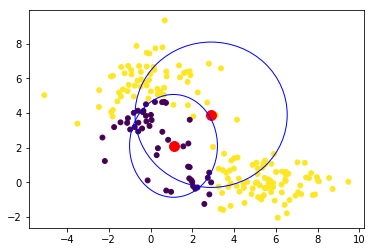

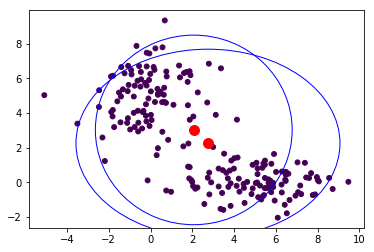

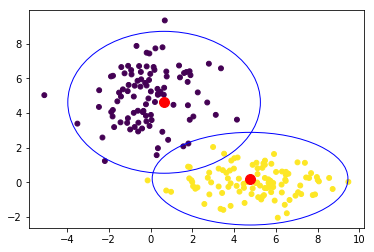

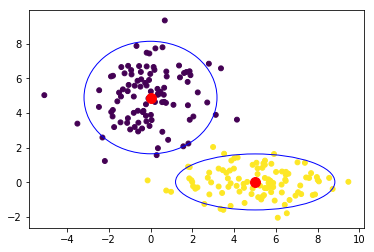

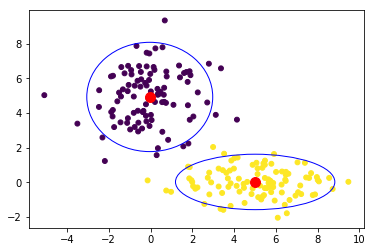

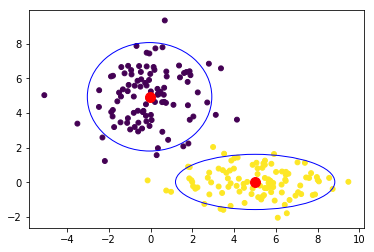

In [10]:
for i in range(251):
    svi.step(data)
    if i % 50 == 0:
        locs = pyro.param('locs')
        scales = pyro.param('scales')
        weights = pyro.param('weights')
        assignment_probs = pyro.param('assignment_probs')
        
        print('locs: {}'.format(locs))
        print('scales: {}'.format(scales))
        print('weights = {}'.format(weights))
        #print('assignments: {}'.format(assignment_probs))
        
        assignments = np.uint8(np.round(assignment_probs.data))
        plot(data, locs.data, scales.data, assignments, figname='pyro_iteration{}.png'.format(i))